In [1]:
!pip install -Uq wandb
!export WANDB_API_KEY="e0aa96a51411bd4bc5a669e117bd1961648ff00e"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# Importo las librerías necesarias.
import os
import gc
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as td
import torchaudio.transforms as tt
from torchaudio.datasets import GTZAN
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive

In [4]:
# Utilizo GPU de estar disponible.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Seteo una semilla para replicabilidad.
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

cuda:0


In [5]:
# Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos
drive.mount('/content/drive')
data_dir = '//content/drive/MyDrive/UTDT/TD6/genres_5sec/'
list_files = os.listdir(data_dir)

# Obtenemos las clases (géneros)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)

# Funciones auxiliares para la clase del dataset
samplerate=22050

# Para obtener generos
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

# Para definir transformación de audios (esto es data leakage hacerlo a todo? hay distintas formas: chequear clasificador.ipynb)
def transform(audio):
    return tt.Spectrogram()(audio)

# Definimos clase para obtener el dataset
class MusicDataset():
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        self.transform = tt.Spectrogram()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]
        spectrogram = self.transform(audio)

        return audio, spectrogram, class_idx

dataset = MusicDataset(data_dir)

Mounted at /content/drive


In [6]:
audio, spec, _ = dataset[0]
import IPython
print(audio.size())
IPython.display.Audio(audio, rate=22050)

torch.Size([1, 110250])


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.imshow(spec.log2()[0,:,:].numpy(),cmap='magma')

In [ ]:
spec = transform(audio)
print(spec.size())
inverse = tt.InverseSpectrogram()
new_audio = inverse(spec.type(torch.complex64))
IPython.display.Audio(new_audio, rate=22050)

In [10]:
audio, spec, label = dataset[0]

# Hiperparámetros
batch_size = 20
learning_rate = 0.02
epochs = 40
type_input = 'waveform' # podría ser sino 'waveform' --> ajustar transform arriba
experiment_name = 'wav_13-11'
project_name = 'TP4'

In [8]:
if type_input == 'spectrogram':
    # Definición del encoder
    class Encoder(nn.Module):
        def __init__(self):
            super(Encoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=10, stride=5, padding=3),
                nn.ReLU(),
                nn.Conv2d(32, 16, kernel_size=2, stride=2, padding=1),
                nn.ReLU()
            )
            self.latent_space = nn.Flatten(1,3)

        def forward(self, x):
            x = self.encoder(x)
            latent_rep = self.latent_space(x)
            return latent_rep

    # Definición del decoder
    class Decoder(nn.Module):
        def __init__(self):
            super(Decoder, self).__init__()
            self.unflatten = nn.Unflatten(1, (20, 21, 56))
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 1, kernel_size=10, stride=5, padding=3, output_padding=2),
                nn.ZeroPad2d((0, 1, 0, 0)),
                nn.ReLU(),
            )

        def forward(self, x):
            x = self.unflatten(x)
            reconstructed_seq = self.decoder(x)
            return reconstructed_seq

    # Definición del Convolutional Autoencoder (CAE)
    class CAE(nn.Module):
        def __init__(self):
            super(CAE, self).__init__()
            self.encoder = Encoder()
            self.decoder = Decoder()

        def forward(self, x):
            latent_rep = self.encoder(x)
            reconstructed_seq = self.decoder(latent_rep)
            return reconstructed_seq, latent_rep

In [9]:
original = torch.rand(1, 201, 552)
print(original.size())
def convoluciones(original):
    vr = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=10, stride=5, padding=3),
                nn.ReLU(),
                nn.Conv2d(32, 16, kernel_size=2, stride=2, padding=1),
                nn.ReLU()
            )
    return vr(original)

def tranpuesta(latent):
    vr = nn.Sequential(
                nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 1, kernel_size=10, stride=5, padding=3, output_padding=2),
                nn.ZeroPad2d((0, 1, 0, 0)),
                nn.ReLU(),
            )
    return vr(latent)

new_tensor = convoluciones(original)
print(new_tensor.size())
func = nn.Flatten(0,2)
flateneado = func(new_tensor)
print(flateneado.size())

reverse = nn.Unflatten(0, (16, 21, 56))
unflat = reverse(flateneado)
unflat.size()
print(unflat.size())
decodeade = tranpuesta(unflat)
print(decodeade.size())

torch.Size([1, 201, 552])
torch.Size([16, 21, 56])
torch.Size([18816])
torch.Size([16, 21, 56])
torch.Size([1, 201, 552])


In [12]:
if type_input == 'waveform':
    # Definición del encoder
    class Encoder(nn.Module):
        def __init__(self):
            super(Encoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv1d(1, 64, kernel_size=8, stride=8, padding=4),
                nn.ReLU(),
                nn.Conv1d(64, 16, kernel_size=4, stride=4, padding=2),
                nn.ReLU(),
                nn.Conv1d(16, 8, kernel_size=2, stride=2, padding=2),
                nn.ReLU(),
            )
            self.latent_space = nn.Flatten()

        def forward(self, x):
            x = self.encoder(x)
            latent_rep = self.latent_space(x)
            return latent_rep

    # Definición del decoder
    class Decoder(nn.Module):
        def __init__(self):
            super(Decoder, self).__init__()
            self.unflatten = nn.Unflatten(1, (8,1725))
            self.decoder = nn.Sequential(
                nn.ConvTranspose1d(8, 16, kernel_size=2, stride=2, padding=2),
                nn.ReLU(),
                nn.ConvTranspose1d(16, 64, kernel_size=4, stride=4, padding=2),
                nn.ReLU(),
                nn.ConvTranspose1d(64, 1, kernel_size=18, stride=8, padding=0),
            )

        def forward(self, x):
            x = self.unflatten(x)
            reconstructed_seq = self.decoder(x)
            return reconstructed_seq

    # Definición del Convolutional Autoencoder (CAE)
    class CAE(nn.Module):
        def __init__(self):
            super(CAE, self).__init__()
            self.encoder = Encoder()
            self.decoder = Decoder()

        def forward(self, x):
            latent_rep = self.encoder(x)
            reconstructed_seq = self.decoder(latent_rep)
            return reconstructed_seq, latent_rep

In [13]:
# Definición del modelo
model = CAE()
model.to(device)
print(model)

# Configuración de wandb
wandb.init(
    project = project_name,
    name = experiment_name,
    config = {
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "type_input": type_input
    }
)

wandb: Currently logged in as: gaston-lm (carrostp3). Use `wandb login --relogin` to force relogin


CAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv1d(1, 64, kernel_size=(8,), stride=(8,), padding=(4,))
      (1): ReLU()
      (2): Conv1d(64, 16, kernel_size=(4,), stride=(4,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(16, 8, kernel_size=(2,), stride=(2,), padding=(2,))
      (5): ReLU()
    )
    (latent_space): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Decoder(
    (unflatten): Unflatten(dim=1, unflattened_size=(8, 1725))
    (decoder): Sequential(
      (0): ConvTranspose1d(8, 16, kernel_size=(2,), stride=(2,), padding=(2,))
      (1): ReLU()
      (2): ConvTranspose1d(16, 64, kernel_size=(4,), stride=(4,), padding=(2,))
      (3): ReLU()
      (4): ConvTranspose1d(64, 1, kernel_size=(18,), stride=(8,))
    )
  )
)


In [14]:
# Divido en training, validation, testing.
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = td.random_split(dataset, [train_size, val_size, test_size])

train_dl = td.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = td.DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_dl = td.DataLoader(test_ds,1, num_workers=2, pin_memory=True)

In [15]:
# Definición de función de perdida (MSE loss la que se suele usar para reconstrucción)
criterion = nn.MSELoss()
# Definición del optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Importante para ir liberando memoria ram
torch.cuda.empty_cache()
gc.collect()

lowest_loss = 1000
best_epoch = -1

for epoch in range(epochs):
    train_losses = []
    # Entrenamiento
    model.train()
    for batch in train_dl:
        optimizer.zero_grad()  # Clear gradients

        inputs, _, _ = batch
        inputs = inputs.to(device)
        # Forward pass
        outputs, _ = model(inputs)

        # Compute reconstruction loss
        loss = torch.sqrt(criterion(outputs, inputs))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Importante para ir liberando memoria ram
        del inputs
        del loss
        del outputs
        torch.cuda.empty_cache()
        gc.collect()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in valid_dl:
            inputs, _, _ = batch
            inputs = inputs.to(device)
            outputs, _ = model(inputs)
            loss = torch.sqrt(criterion(outputs, inputs))
            val_losses.append(loss.item())

    # Importante para ir liberando memoria ram
    del inputs
    del loss
    del outputs
    torch.cuda.empty_cache()
    gc.collect()

    # Para estadisticas de wandb
    if val_losses[-1] < lowest_loss:
        lowest_loss = val_losses[-1]
        best_epoch = epoch
        best_model_state_dict = model.state_dict()

    wandb.log({"train_loss": train_losses[-1], "val_loss": val_losses[-1]})

    # Print progress
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {np.mean(train_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}')

# Indico por consola cuando finalizó el entrenamiento
print(f"Entrenamiento finalizado, la loss más baja fue {str(lowest_loss)} la mejor epoch:{str(best_epoch)}")

wandb.log({"lowest_loss": lowest_loss, "best_epoch": best_epoch})

# Guardo el modelo entrenado en disco
PATH = './cae.pth'
torch.save(best_model_state_dict, PATH)
wandb.finish()

Epoch [1/40], Training Loss: 0.1617, Validation Loss: 0.1227
Epoch [2/40], Training Loss: 0.1160, Validation Loss: 0.1031
Epoch [3/40], Training Loss: 0.1002, Validation Loss: 0.0952
Epoch [4/40], Training Loss: 0.0917, Validation Loss: 0.0900
Epoch [5/40], Training Loss: 0.0879, Validation Loss: 0.0879
Epoch [6/40], Training Loss: 0.0857, Validation Loss: 0.0823
Epoch [7/40], Training Loss: 0.0825, Validation Loss: 0.0809
Epoch [8/40], Training Loss: 0.0795, Validation Loss: 0.0847
Epoch [9/40], Training Loss: 0.0826, Validation Loss: 0.0826
Epoch [10/40], Training Loss: 0.0786, Validation Loss: 0.0772
Epoch [11/40], Training Loss: 0.0759, Validation Loss: 0.0769
Epoch [12/40], Training Loss: 0.0765, Validation Loss: 0.0758
Epoch [13/40], Training Loss: 0.0737, Validation Loss: 0.0770
Epoch [14/40], Training Loss: 0.0730, Validation Loss: 0.0730
Epoch [15/40], Training Loss: 0.0725, Validation Loss: 0.0708
Epoch [16/40], Training Loss: 0.0713, Validation Loss: 0.0726
Epoch [17/40], Tr

best_epoch,▁
lowest_loss,▁
train_loss,█▅▅▃▃▇▃▄▄▄▃▃▂▂▃▃▃▄▂▁▂▁▂▃▃▂▂▂▃▄▁▄▄▄▃▁▁▂▂▃
val_loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,37
lowest_loss,0.06722
train_loss,0.06825
val_loss,0.06919


In [16]:
# Load the best model
S = torch.load('cae.pth')
model.load_state_dict(S)

<All keys matched successfully>

In [18]:
model.eval()

reconstructed_audios_list = []

for audio, _, _ in test_dl:

    audio = audio.to(device)

    with torch.no_grad():
        # Forward pass
        reconstructed_output, latent_vec = model(audio)
        # print(latent_vec.size())
        # Save the reconstructed output to the list
        reconstructed_audios_list.append(reconstructed_output.squeeze(0).cpu())

In [19]:
wav, spec, _ = test_dl.dataset[12]
reconstructed_audio = reconstructed_audios_list[12]

In [20]:
import IPython
IPython.display.Audio(wav, rate=22050)

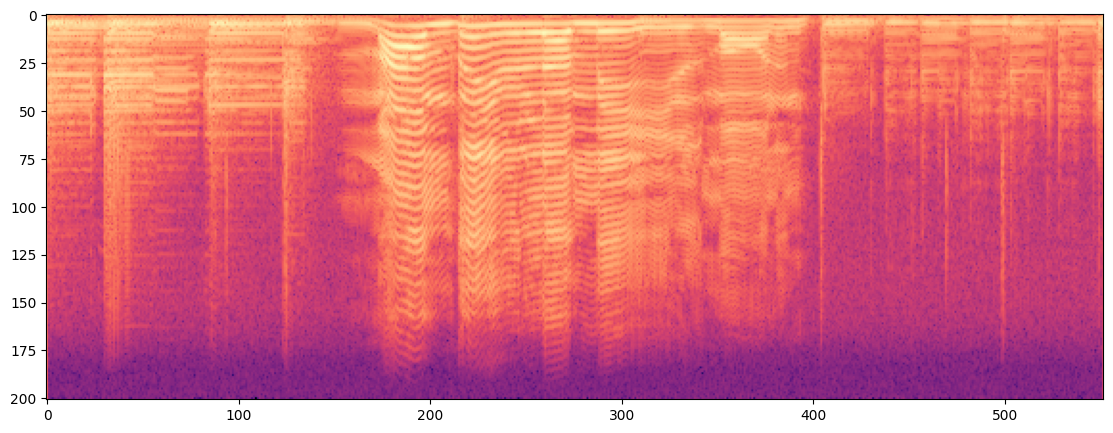

In [21]:
plt.figure(figsize=(20, 5))
plt.imshow(spec.log2()[0,:,:].numpy(),cmap='magma')

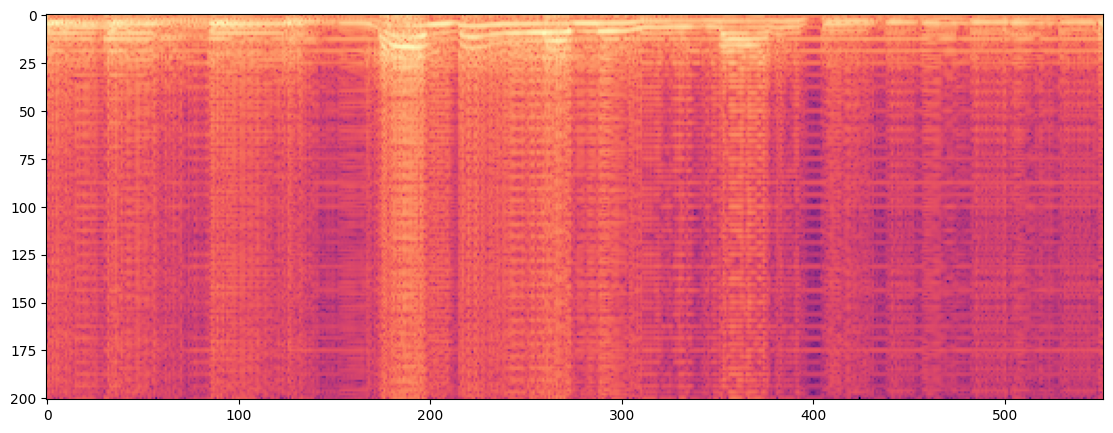

In [22]:
reconstructed_spec = transform(reconstructed_audio)

plt.figure(figsize=(20, 5))
plt.imshow(reconstructed_spec.log2()[0,:,:].numpy(),cmap='magma')

In [23]:
# inverse = tt.InverseSpectrogram()
# new_audio = inverse(reconstructed_spec.type(torch.complex64))
IPython.display.Audio(reconstructed_audio, rate=22050)

In [ ]:
# plt.figure(figsize=(20, 5))
# plt.imshow(reconstructed_spec.log2()[0,:,:].numpy(),cmap='magma')